In [1]:
import pickle
import numpy
import math
import json

import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
from matplotlib import cm
import matplotlib as mpl

from evaluator import define_parameters, define_fitness_calculator

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['viridis']

In [2]:
optimization_folder = "20250225-081942_Optimization"
config_optimisation = "./param_split/config_optimisation"
checkpoint_path = f"./{optimization_folder}/opt_check.pkl"

In [3]:
with open(config_optimisation) as f:
    opt_config = json.load(f)
fitness_calculator = define_fitness_calculator(opt_config)
params = define_parameters(opt_config)
param_names = [p.name for p in params]
scores_names = [target.name for target in fitness_calculator.objectives]

for p in params:
    print(p.name, p.bounds)

sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight [5e-05, 0.00021]
sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight [0.00024, 0.00032]
sheets.l4_cortex_exc.AfferentConnection.base_weight [0.0015, 0.004]
sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight [0.0012, 0.003]
sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight [0.0012, 0.0035]
sheets.l4_cortex_inh.AfferentConnection.base_weight [0.0015, 0.004]
sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight [5e-06, 0.00015]
sheets.l23_cortex_exc.L23ExcL23ExcConnection_biais.base_weight [5e-06, 0.00015]
sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight [5e-05, 0.00035]
sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight [0.0005, 0.0028]
sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight [0.00018, 0.0004]
sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight [5e-05, 0.0003]
sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight [0.0012, 0.0035]
sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight [

In [4]:
with open(checkpoint_path, "rb") as fp:
    run = pickle.load(fp, encoding="latin1")

# Plot best solution

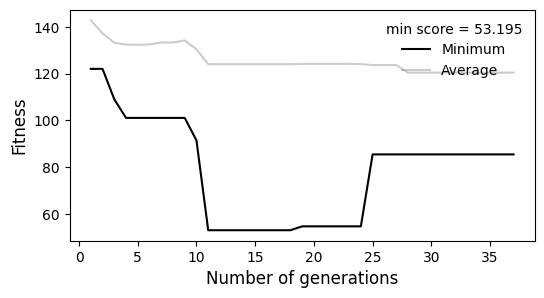

In [5]:
fig, axs = plt.subplots(1, figsize=(6, 3), squeeze=False)

axs[0, 0].plot(run["logbook"].select("gen"), run["logbook"].select("min"), label="Minimum", c="black")
axs[0, 0].plot(run["logbook"].select("gen"), run["logbook"].select("avg"), label="Average", c="gray", alpha=0.4)

axs[0, 0].set_xlabel("Number of generations", size="large")
axs[0, 0].set_ylabel("Fitness", size="large")

legend_text = "\n".join((f"min score = {min(run['logbook'].select('min')):.3f}",))
axs[0, 0].legend(title=legend_text, loc="upper right", frameon=False)

plt.savefig(f"./{optimization_folder}/evo_fitness.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

In [15]:
print("Sigma: ", run["CMA_es"].sigma)
print("Best model:")
print("{")
for p, v in zip(param_names, run["halloffame"][0]):
    print(f'    "{p}": [{round(v, 8)}],')
print("}")

print(run["halloffame"][0])

Sigma:  0.16760820632122747
Best model:
{
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [6.985e-05],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00028891],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00234931],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.00248883],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.00298567],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.00370125],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [2.592e-05],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection_biais.base_weight": [0.00011493],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00024773],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.00236014],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00019799],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00017185],
    "sheets.l23_cortex_inh.L23InhL23ExcConn

In [16]:
reference_parameters = {
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00018],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00022],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.0012],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.001],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.001],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.0012],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [0.00018],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00035],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.001],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00018],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00022],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.0009],
    "sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight": [0.0009],
    "sheets.l23_cortex_inh.L4ExcL23InhConnection.base_weight": [0.001],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.U": [0.75],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.tau_rec": [30],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.short_term_plasticity.tau_rec": [70],
    "sheets.l4_cortex_exc.AfferentConnection.short_term_plasticity.tau_rec": [125],
}

for p, v in zip(param_names, run["halloffame"][0]):
    if p in reference_parameters:
        _diff = 100 * (v - reference_parameters[p][0]) / reference_parameters[p][0]
        print(f'{p}: {round(v, 8)} ({_diff:.2f})%')

sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight: 6.985e-05 (-61.20)%
sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight: 0.00028891 (31.32)%
sheets.l4_cortex_exc.AfferentConnection.base_weight: 0.00234931 (95.78)%
sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight: 0.00248883 (148.88)%
sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight: 0.00298567 (198.57)%
sheets.l4_cortex_inh.AfferentConnection.base_weight: 0.00370125 (208.44)%
sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight: 2.592e-05 (-85.60)%
sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight: 0.00024773 (-29.22)%
sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight: 0.00236014 (136.01)%
sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight: 0.00019799 (10.00)%
sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight: 0.00017185 (-21.88)%
sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight: 0.00253562 (181.74)%
sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight: 0.0003 (-66.67)%
sheets.

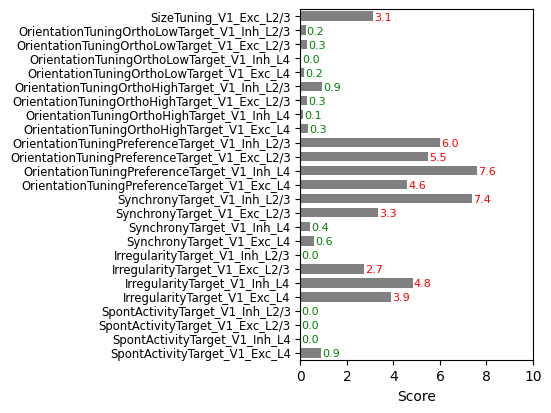

In [17]:
score = [float(f) for f in run["halloffame"][0].fitness.values]
pos = [*range(len(score))]

fig, axs = plt.subplots(1, figsize=(3, 0.8 + 0.150 * len(pos)), squeeze=False)

axs[0, 0].barh(pos, score, height=0.7, align="center", color="gray")

for p, s in zip(pos, score):
    if s > 2:
        axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="red", fontsize=8)
    if s < 2:
        axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="green", fontsize=8)

axs[0, 0].set_xlabel("Score")

axs[0, 0].set_yticks(pos)
axs[0, 0].set_yticklabels(scores_names, size="small")

axs[0, 0].set_xlim(0, 10)
axs[0, 0].set_ylim(-0.5, len(pos) - 0.5)

plt.savefig(f"./figures/scores_{optimization_folder}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot correlation between parameters and scores

In [18]:
# This is an approximation since the other parameters are not fix
from scipy.stats import pearsonr

n_params = len(run["halloffame"][0])
n_targets = len(run["halloffame"][0].fitness.values)

corrs = []
for idx_param in range(n_params):

    for idx_targets in range(n_targets):

        X = []
        Y = []

        for idx_pop in run['history'].genealogy_history:
            ind = run['history'].genealogy_history[idx_pop]
            scores = numpy.array([float(v) for v in ind.fitness.values])
            X.append(ind[idx_param])
            Y.append(scores[idx_targets])

        corrs.append(pearsonr(X, Y)[0])

        """if "L23ExcL23Exc" in  param_names[idx_param]:
            plt.scatter(X, Y)
            plt.title(scores_names[idx_targets])
            plt.show()"""

corrs = numpy.array(corrs).reshape(n_params, n_targets)

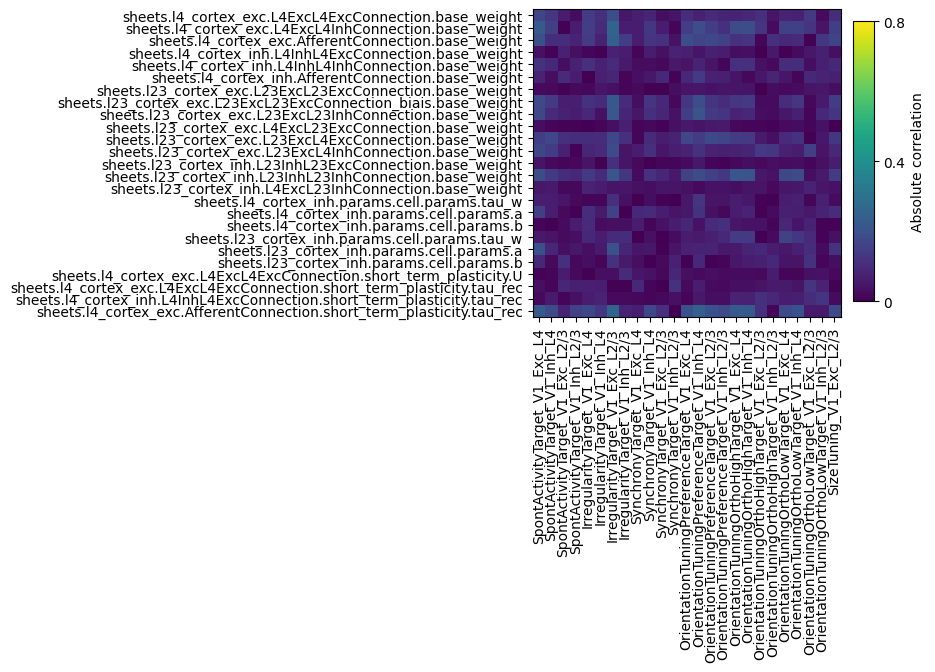

In [19]:
fig, ax = plt.subplots(1, figsize=(7, 4))

ax.imshow(numpy.abs(corrs), vmin=0, vmax=0.8)

ax.set_xticks(range(n_targets))
ax.set_xticklabels(scores_names, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels(param_names)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.75, 0.15, 0.03, 0.7])
norm = mpl.colors.Normalize(vmin=0, vmax=0.8)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax, orientation='vertical', label='Absolute correlation'
)
cbar.ax.set_yticks([0, 0.4, 0.8])
cbar.ax.set_yticklabels([0, 0.4, 0.8])

plt.savefig(f"./{optimization_folder}/correlations.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot the CMA matrix

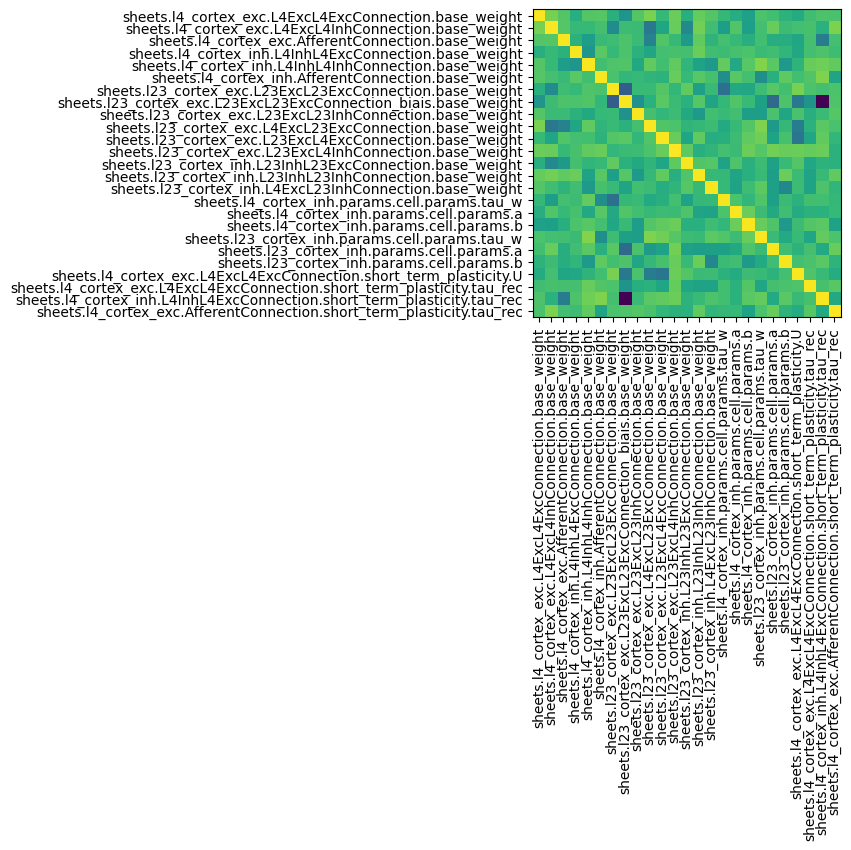

In [20]:
fig, ax = plt.subplots(1, figsize=(4, 4))

_im = numpy.log(numpy.abs(run["CMA_es"].C))
ax.imshow(_im, vmin=_im.min(), vmax=_im.max())

ax.set_xticks(range(n_params))
ax.set_xticklabels(param_names, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels(param_names)
    
plt.savefig(f"./{optimization_folder}/covariance_matrix.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot exploration of the parameter space

/tmp/ipykernel_1657028/1912367237.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


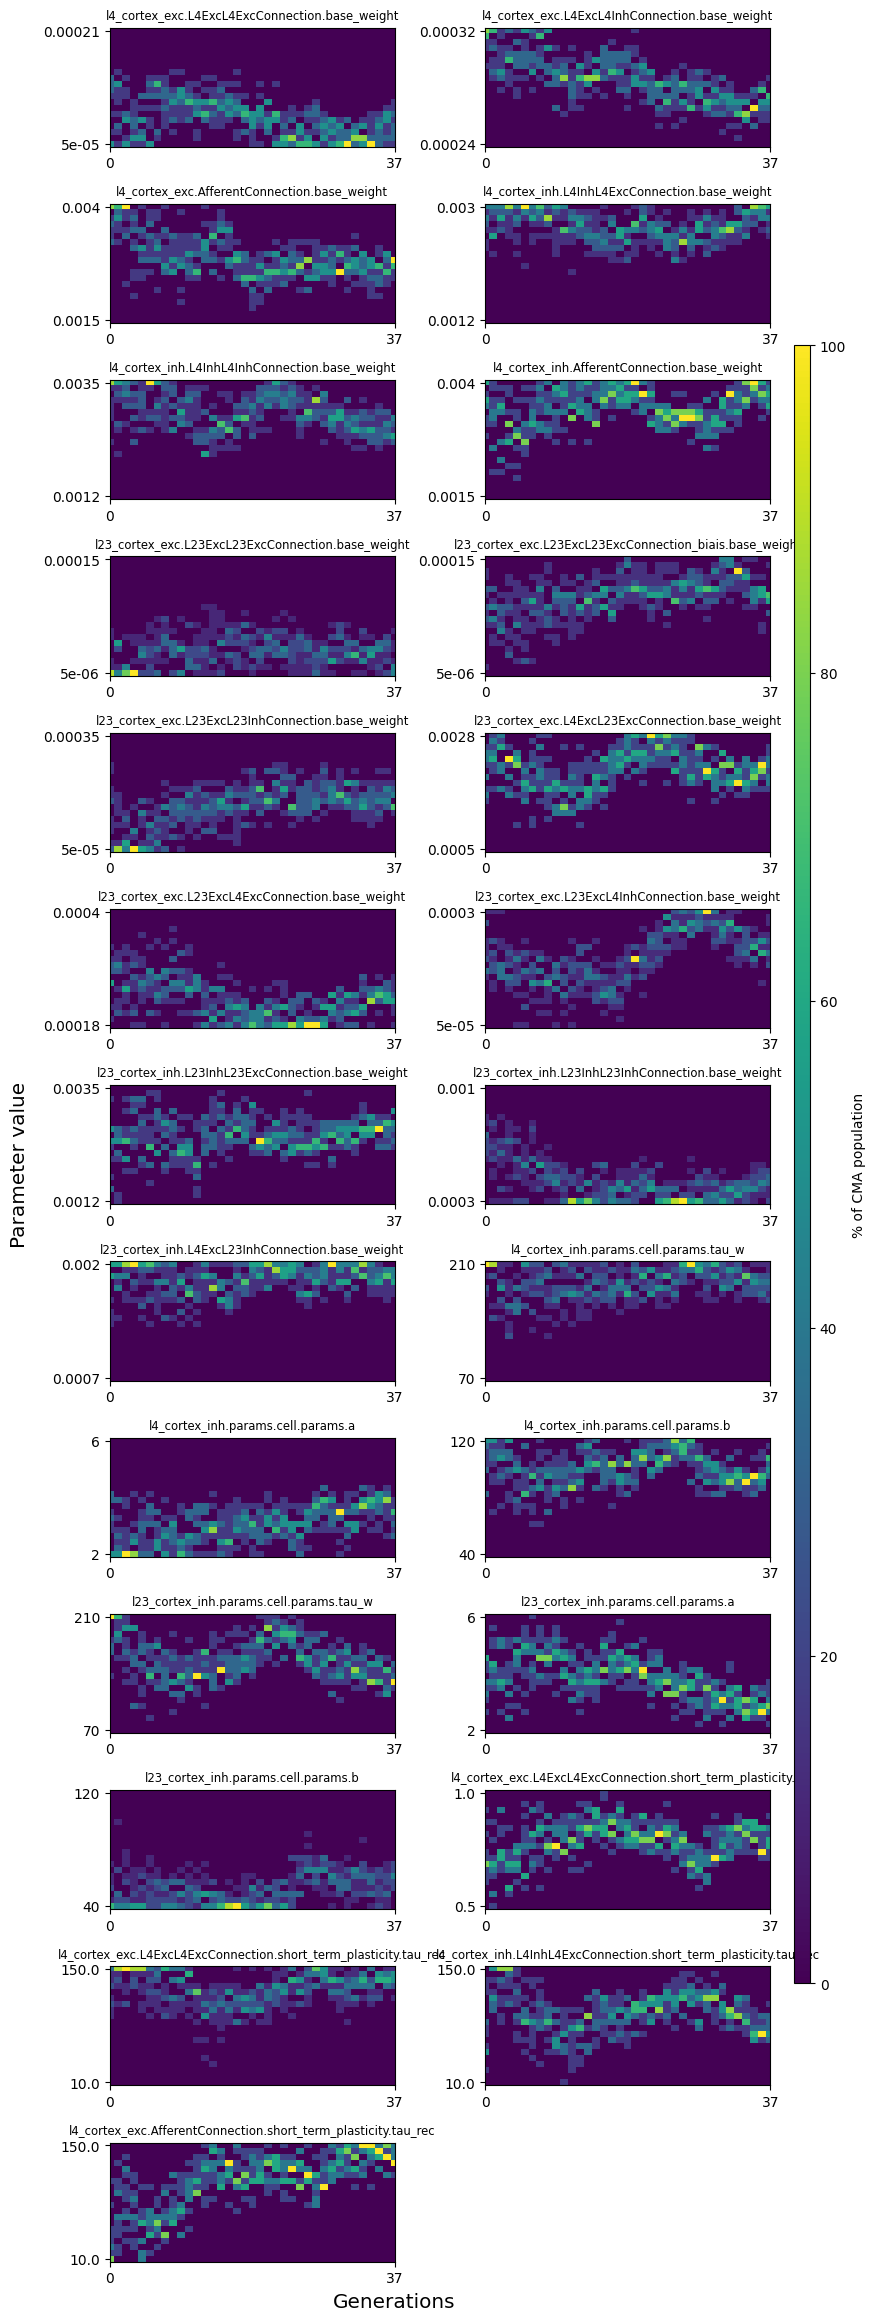

In [21]:
max_n_gen = run["generation"]
gen_per_bin = 1
pop_size = len(run["population"])
histo_bins = (int(max_n_gen / gen_per_bin), 20)
normalization_factor = gen_per_bin * pop_size

# Get the histograms for all parameters
histograms = {}
for param_index in range(len(run["history"].genealogy_history[1])):
    x = [(ind_idx - 1) // pop_size for ind_idx in run["history"].genealogy_history.keys()]
    y = [ind[param_index] for ind in run["history"].genealogy_history.values()]

    histo_range = [
        [0, max_n_gen],
        [
            params[param_index].bounds[0],
            params[param_index].bounds[1],
        ],
    ]

    h, _, _ = numpy.histogram2d(x, y, bins=histo_bins, range=histo_range)
    normalized_h = h / normalization_factor

    histograms[param_index] = normalized_h

ncols = 2
nrows = math.ceil(len(params) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 1.8 * nrows))
axs = axs.flat

# Plot the histograms
for param_index, param in enumerate(params):
    axs[param_index].imshow(
        100.0 * numpy.flip(histograms[param_index].T, 0),
        aspect="auto",
        interpolation="none",
    )

    axs[param_index].set_title(list(param_names)[param_index].replace("sheets.", ""), size="small")

    x_ticks_pos = [0, int(max_n_gen / gen_per_bin) - 1]
    x_ticks_label = [0, int(max_n_gen / gen_per_bin) * gen_per_bin]
    axs[param_index].set_xticks(x_ticks_pos, x_ticks_label)
    axs[param_index].set_yticks([0, 19], [param.bounds[1], param.bounds[0]])
    axs[param_index].set_xlim(0, int(max_n_gen / gen_per_bin) - 1)

for axs_index in range(len(params), len(axs)):
    axs[axs_index].set_visible(False)

# Add a colorbar common to all subplots
norm = plt_colors.Normalize(vmin=0, vmax=100, clip=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax, label="% of CMA population",)

fig.supxlabel("Generations", size="x-large")
fig.supylabel("Parameter value", size="x-large")

plt.tight_layout()

plt.savefig(f"./{optimization_folder}/evo_parameters.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

In [22]:
p1 = {
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00017231],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00026298],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00167932],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.00157516],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.0017],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.00240411],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [7.75e-06],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00019637],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.00204628],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00028667],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00018196],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.00214095],
    "sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight": [0.00050657],
    "sheets.l23_cortex_inh.L4ExcL23InhConnection.base_weight": [0.00094136],
    "sheets.l4_cortex_inh.params.cell.params.tau_w": [177.08156935],
    "sheets.l4_cortex_inh.params.cell.params.a": [2.5109949],
    "sheets.l4_cortex_inh.params.cell.params.b": [47.34271682],
    "sheets.l23_cortex_inh.params.cell.params.tau_w": [138.28441625],
    "sheets.l23_cortex_inh.params.cell.params.a": [4.61450943],
    "sheets.l23_cortex_inh.params.cell.params.b": [41.36709645],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.U": [0.89821248],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.tau_rec": [14.65271864],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.short_term_plasticity.tau_rec": [39.14671538],
    "sheets.l4_cortex_exc.AfferentConnection.short_term_plasticity.tau_rec": [119.4830653],
}

p2 = {
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00012371],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.0002971],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00213231],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.00201003],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.00277724],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.00249477],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [6.41e-06],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00016059],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.00161867],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00036719],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00020311],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.00249985],
    "sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight": [0.0007334],
    "sheets.l23_cortex_inh.L4ExcL23InhConnection.base_weight": [0.00110945],
    "sheets.l4_cortex_inh.params.cell.params.tau_w": [76.17256024],
    "sheets.l4_cortex_inh.params.cell.params.a": [3.56250822],
    "sheets.l4_cortex_inh.params.cell.params.b": [48.06020686],
    "sheets.l23_cortex_inh.params.cell.params.tau_w": [99.31587759],
    "sheets.l23_cortex_inh.params.cell.params.a": [5.57301634],
    "sheets.l23_cortex_inh.params.cell.params.b": [50.22330442],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.U": [0.91720166],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.tau_rec": [136.4720665],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.short_term_plasticity.tau_rec": [45.24974672],
    "sheets.l4_cortex_exc.AfferentConnection.short_term_plasticity.tau_rec": [138.0648628],
}

p3 = {
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00014628],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00028055],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00130547],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.00118972],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.00132694],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.00162447],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [3.811e-05],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00018623],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.00172112],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.0003491],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00022506],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.00347213],
    "sheets.l23_cortex_inh.L23InhL23InhConnection.base_weight": [0.00058415],
    "sheets.l23_cortex_inh.L4ExcL23InhConnection.base_weight": [0.00085439],
    "sheets.l4_cortex_inh.params.cell.params.tau_w": [79.28592],
    "sheets.l4_cortex_inh.params.cell.params.a": [3.27125966],
    "sheets.l4_cortex_inh.params.cell.params.b": [51.56410977],
    "sheets.l23_cortex_inh.params.cell.params.tau_w": [136.91716338],
    "sheets.l23_cortex_inh.params.cell.params.a": [4.92307142],
    "sheets.l23_cortex_inh.params.cell.params.b": [67.67296789],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.U": [0.95544135],
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.short_term_plasticity.tau_rec": [27.33935244],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.short_term_plasticity.tau_rec": [22.31884732],
    "sheets.l4_cortex_exc.AfferentConnection.short_term_plasticity.tau_rec": [88.03835315],
}

In [23]:
 # Normalizes the parameters and makes sure they are listed in the same order
lbounds = {p.name: p.bounds[0] for p in params}
ubounds = {p.name: p.bounds[1] for p in params}

data = []
parameters = list(lbounds.keys())
for ps in [p1, p2, p3]:
    _ = []
    for param in parameters:
        bm = (ubounds[param] + lbounds[param]) / 2.0
        br = (ubounds[param] - lbounds[param]) / 2.0
        _.append((ps[param][0] - bm) / br)
    data.append(_)
data = numpy.array(data)

figure_width = 2.5 + 0.08 * max(len(pn) for pn in ubounds.keys())
figure_height = 0.8 + 0.21 * len(ubounds)
fig, axs = plt.subplots(1, figsize=(figure_width, figure_height), squeeze=False)

v = axs[0, 0].violinplot(data, vert=False)

for partname in ("cbars", "cmins", "cmaxes", "cmeans", "cmedians"):
    if partname in v:
        vp = v[partname]
        vp.set_edgecolor("black")
for pc in v["bodies"]:
    pc.set_facecolor("black")

axs[0, 0].set_yticks(ticks=range(1, 1 + len(ubounds)))
axs[0, 0].set_yticklabels(labels=list(ubounds.keys()))

# Guides for the eye
for p in range(len(ubounds)):
    axs[0, 0].plot([-1, 1], [p + 1, p + 1], c="black", ls="dotted", alpha=0.7, lw=0.7, zorder=1)
axs[0, 0].plot([-1, -1], [0, 1 + len(ubounds)], c="black", ls="--", alpha=0.8, zorder=1)
axs[0, 0].plot([0, 0], [0, 1 + len(ubounds)], c="black", ls="--", alpha=0.8, zorder=1)
axs[0, 0].plot([1, 1], [0, 1 + len(ubounds)], c="black", ls="--", alpha=0.8, zorder=1)

axs[0, 0].set_xticks(ticks=[-1, 0, 1])
axs[0, 0].set_xticklabels(labels=["Lower bounds", "50%", "Upper bounds"], rotation=90)

axs[0, 0].set_ylim(0, 1 + len(ubounds))
axs[0, 0].set_xlim(-1.05, 1.05)

for _, spine in axs[0, 0].spines.items():
    spine.set_visible(False)

plt.tight_layout()

plt.show()

KeyError: 'sheets.l23_cortex_exc.L23ExcL23ExcConnection_biais.base_weight'